# Import Libraries

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import joblib

# Data Loading

In [296]:
# load csv
df_ori = pd.read_csv("airflow_ES/dags/clean_customer_churn.csv")

/var/folders/p9/gm0ht_316hz7l88qvw1tylxw0000gn/T/ipykernel_18874/1914654348.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ori = pd.read_csv("airflow_ES/dags/clean_customer_churn.csv")


In [297]:
df = df_ori.copy()

# show df
df

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,True
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,True
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,True
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,True
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,False
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,False
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,False
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,False


In [298]:
# check missing value
df.isnull().sum()

customerid           1
age                  1
gender               1
tenure               1
usage_frequency      1
support_calls        1
payment_delay        1
subscription_type    1
contract_length      1
total_spend          1
last_interaction     1
churn                1
dtype: int64

In [299]:
# check data row missing value
df[df.isnull().any(axis=1)]

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
# drop missing 
df = df.dropna()

In [301]:
# check missing value
df.isnull().sum()

customerid           0
age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
last_interaction     0
churn                0
dtype: int64

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customerid         440832 non-null  float64
 1   age                440832 non-null  float64
 2   gender             440832 non-null  object 
 3   tenure             440832 non-null  float64
 4   usage_frequency    440832 non-null  float64
 5   support_calls      440832 non-null  float64
 6   payment_delay      440832 non-null  float64
 7   subscription_type  440832 non-null  object 
 8   contract_length    440832 non-null  object 
 9   total_spend        440832 non-null  float64
 10  last_interaction   440832 non-null  float64
 11  churn              440832 non-null  object 
dtypes: float64(8), object(4)
memory usage: 43.7+ MB


In [303]:
df["customerid"] = df["customerid"].astype(int)
df["age"] = df["age"].astype(int)
df["tenure"] = df["tenure"].astype(int)
df["usage_frequency"] = df["usage_frequency"].astype(int)
df["support_calls"] = df["support_calls"].astype(int)
df["payment_delay"] = df["payment_delay"].astype(int)
df["last_interaction"] = df["last_interaction"].astype(int)
df["churn"] = df["churn"].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customerid         440832 non-null  int64  
 1   age                440832 non-null  int64  
 2   gender             440832 non-null  object 
 3   tenure             440832 non-null  int64  
 4   usage_frequency    440832 non-null  int64  
 5   support_calls      440832 non-null  int64  
 6   payment_delay      440832 non-null  int64  
 7   subscription_type  440832 non-null  object 
 8   contract_length    440832 non-null  object 
 9   total_spend        440832 non-null  float64
 10  last_interaction   440832 non-null  int64  
 11  churn              440832 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 43.7+ MB


/var/folders/p9/gm0ht_316hz7l88qvw1tylxw0000gn/T/ipykernel_18874/1879613878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["customerid"] = df["customerid"].astype(int)
/var/folders/p9/gm0ht_316hz7l88qvw1tylxw0000gn/T/ipykernel_18874/1879613878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age"] = df["age"].astype(int)
/var/folders/p9/gm0ht_316hz7l88qvw1tylxw0000gn/T/ipykernel_18874/1879613878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customerid         440832 non-null  int64  
 1   age                440832 non-null  int64  
 2   gender             440832 non-null  object 
 3   tenure             440832 non-null  int64  
 4   usage_frequency    440832 non-null  int64  
 5   support_calls      440832 non-null  int64  
 6   payment_delay      440832 non-null  int64  
 7   subscription_type  440832 non-null  object 
 8   contract_length    440832 non-null  object 
 9   total_spend        440832 non-null  float64
 10  last_interaction   440832 non-null  int64  
 11  churn              440832 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 43.7+ MB


# EDA

## Age

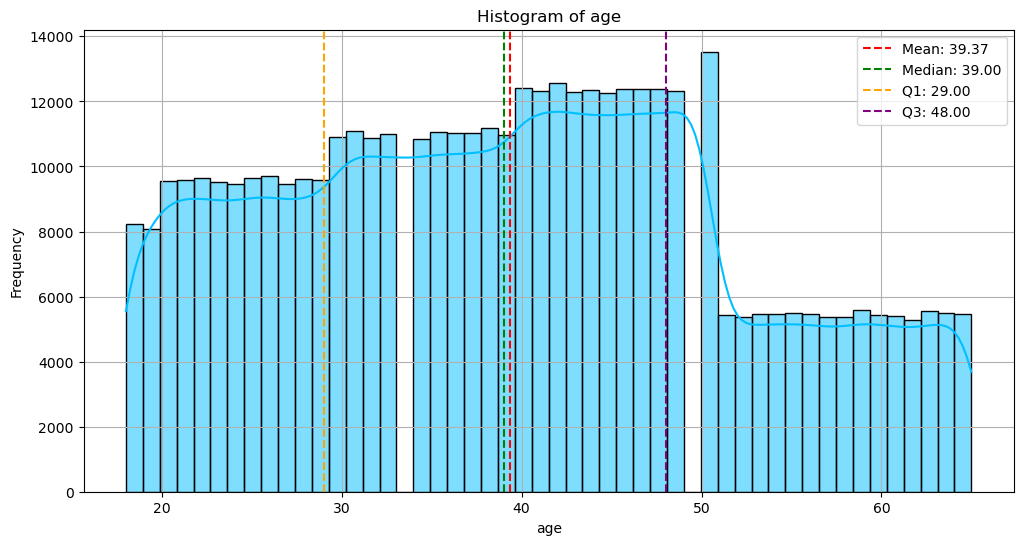

In [387]:
# statistic
mean_age = df["age"].mean()
median_age = df["age"].median()
q1_age = df["age"].quantile(0.25)
q3_age = df["age"].quantile(0.75)

# plot
plt.figure(figsize=(12,6))
sns.histplot(df["age"], bins=50, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_age, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_age:.2f}")
plt.axvline(median_age, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_age:.2f}")
plt.axvline(q1_age, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_age:.2f}")
plt.axvline(q3_age, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_age:.2f}")

# label
plt.title("Histogram of age")
plt.xlabel("age")
plt.ylabel("Frequency")
plt.legend()

# show plot
plt.grid(True)
plt.show()

## Gender

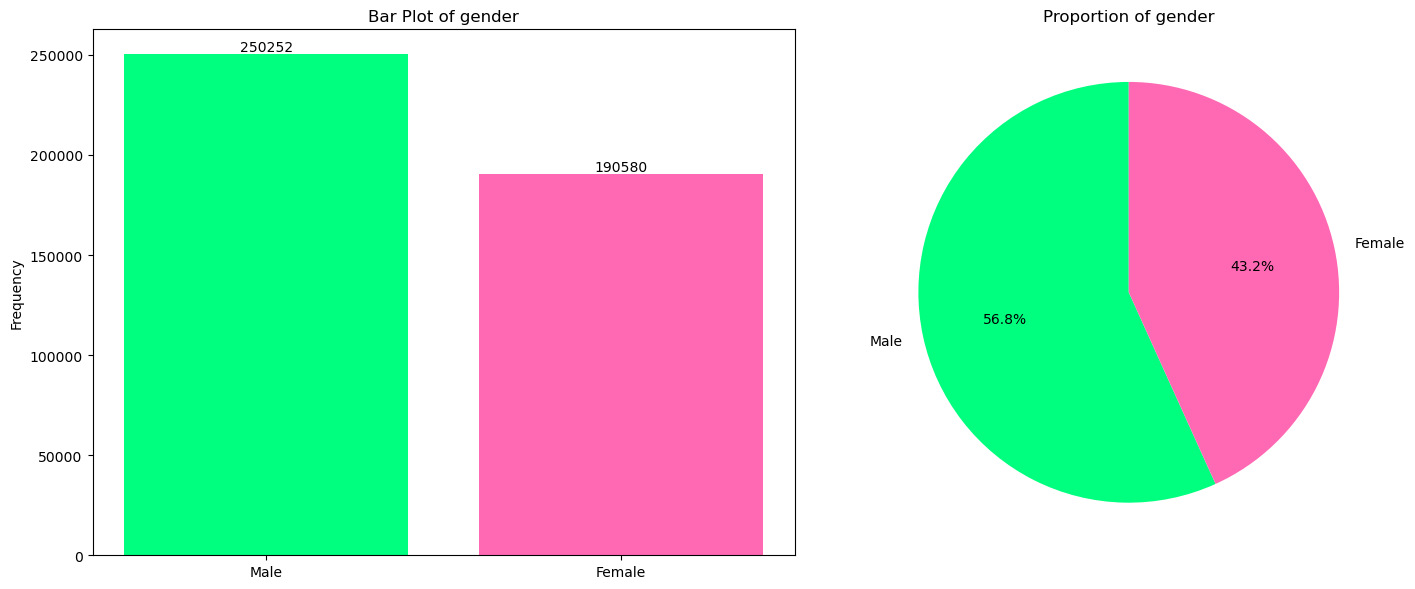

In [393]:
# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# barplot
dpnm_counts = df["gender"].value_counts()
barplot = ax1.bar(dpnm_counts.index, dpnm_counts.values, color=["springgreen", "hotpink"])

# label barplot
for bar, count in zip(barplot, dpnm_counts.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha="center", va="bottom")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["Male", "Female"])
ax1.set_ylabel("Frequency")
ax1.set_title("Bar Plot of gender")

# pie chart
dpnm_labels = ["Male", "Female"]
dpnm_sizes = df["gender"].value_counts().values
ax2.pie(dpnm_sizes, labels=dpnm_labels, autopct="%1.1f%%", colors=["springgreen", "hotpink"], startangle=90)

# label peichart
ax2.set_title("Proportion of gender")

# show plot
plt.tight_layout()
plt.show()

## Tenure

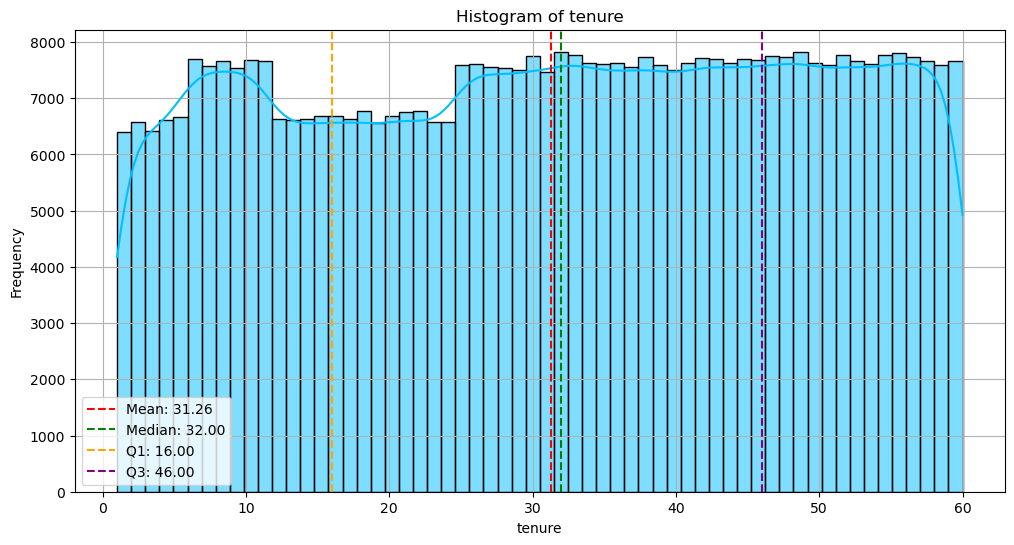

In [400]:
# statistic
mean_tenure = df["tenure"].mean()
median_tenure = df["tenure"].median()
q1_tenure = df["tenure"].quantile(0.25)
q3_tenure = df["tenure"].quantile(0.75)

# plot
plt.figure(figsize=(12,6))
sns.histplot(df["tenure"], bins=60, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_tenure, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_tenure:.2f}")
plt.axvline(median_tenure, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_tenure:.2f}")
plt.axvline(q1_tenure, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_tenure:.2f}")
plt.axvline(q3_tenure, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_tenure:.2f}")

# label
plt.title("Histogram of tenure")
plt.xlabel("tenure")
plt.ylabel("Frequency")
plt.legend()

# show plot
plt.grid(True)
plt.show()

## usage_frequency

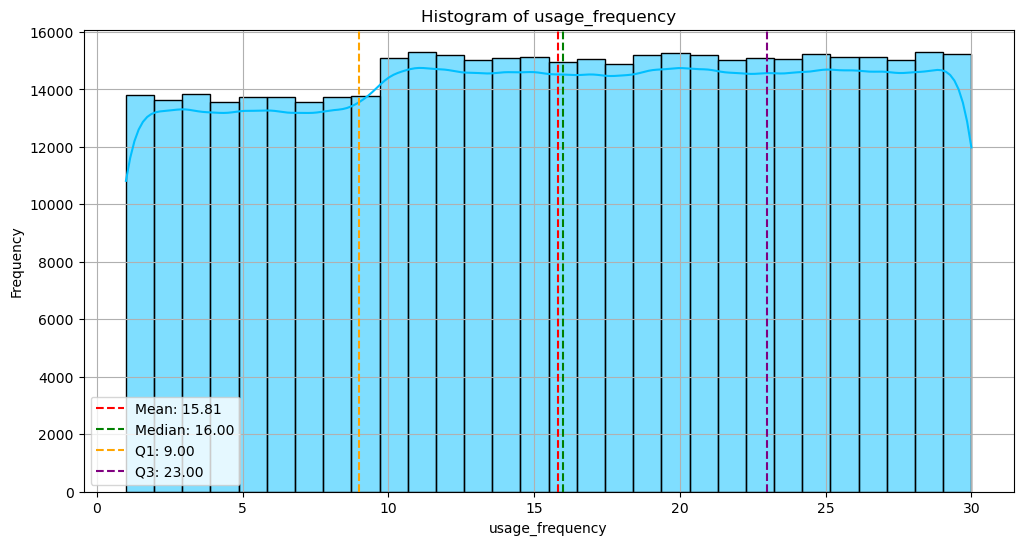

In [404]:
# statistic
mean_usage_frequency = df["usage_frequency"].mean()
median_usage_frequency = df["usage_frequency"].median()
q1_usage_frequency = df["usage_frequency"].quantile(0.25)
q3_usage_frequency = df["usage_frequency"].quantile(0.75)

# plot
plt.figure(figsize=(12,6))
sns.histplot(df["usage_frequency"], bins=30, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_usage_frequency, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_usage_frequency:.2f}")
plt.axvline(median_usage_frequency, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_usage_frequency:.2f}")
plt.axvline(q1_usage_frequency, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_usage_frequency:.2f}")
plt.axvline(q3_usage_frequency, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_usage_frequency:.2f}")

# label
plt.title("Histogram of usage_frequency")
plt.xlabel("usage_frequency")
plt.ylabel("Frequency")
plt.legend()

# show plot
plt.grid(True)
plt.show()

## support_calls

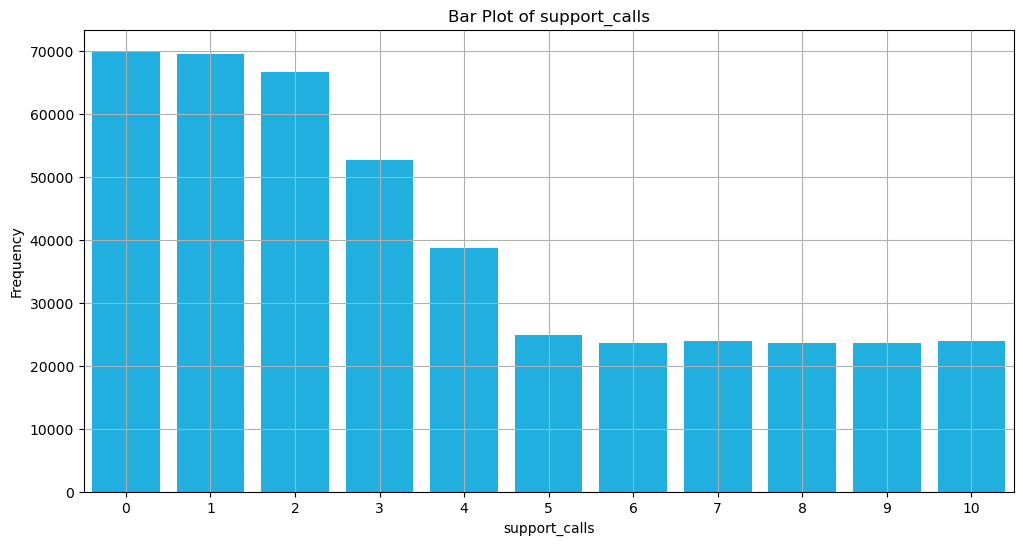

In [407]:
# unique value counts support_calls
value_counts = df["support_calls"].value_counts().sort_index()

# plot
plt.figure(figsize=(12,6))
sns.barplot(x=value_counts.index, y=value_counts.values, color="deepskyblue")

# label
plt.title("Bar Plot of support_calls")
plt.xlabel("support_calls")
plt.ylabel("Frequency")

# show plot
plt.grid(True)
plt.show()

## payment_delay

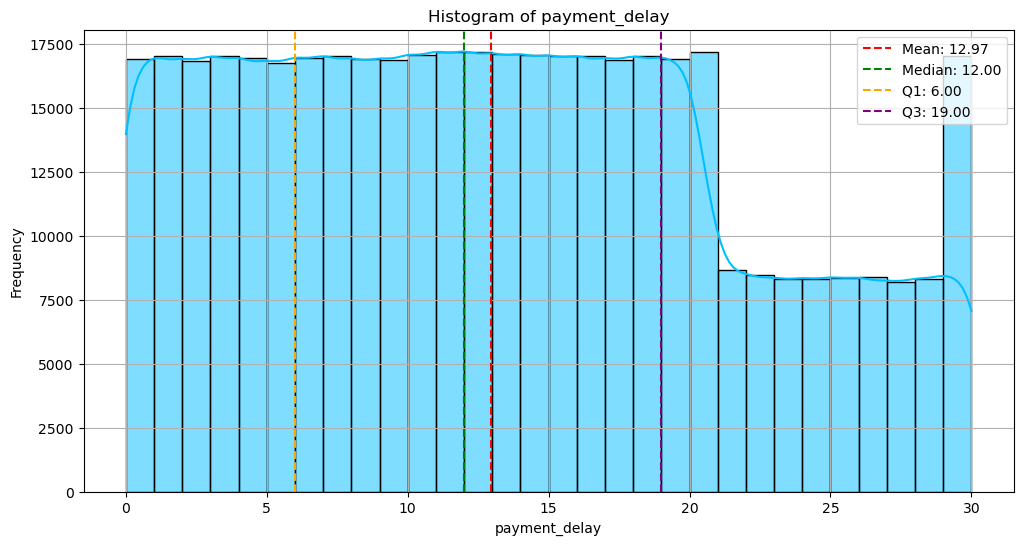

In [412]:
# statistic
mean_payment_delay = df["payment_delay"].mean()
median_payment_delay = df["payment_delay"].median()
q1_payment_delay = df["payment_delay"].quantile(0.25)
q3_payment_delay = df["payment_delay"].quantile(0.75)

# plot
plt.figure(figsize=(12,6))
sns.histplot(df["payment_delay"], bins=30, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_payment_delay, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_payment_delay:.2f}")
plt.axvline(median_payment_delay, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_payment_delay:.2f}")
plt.axvline(q1_payment_delay, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_payment_delay:.2f}")
plt.axvline(q3_payment_delay, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_payment_delay:.2f}")

# label
plt.title("Histogram of payment_delay")
plt.xlabel("payment_delay")
plt.ylabel("Frequency")
plt.legend()

# show plot
plt.grid(True)
plt.show()

## total_spend

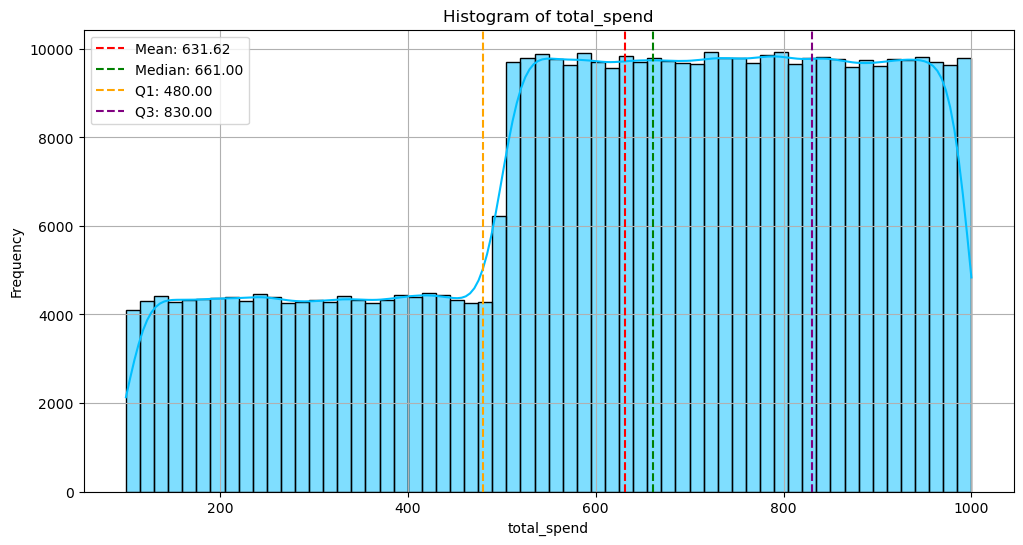

In [413]:
# statistic
mean_total_spend = df["total_spend"].mean()
median_total_spend = df["total_spend"].median()
q1_total_spend = df["total_spend"].quantile(0.25)
q3_total_spend = df["total_spend"].quantile(0.75)

# plot
plt.figure(figsize=(12,6))
sns.histplot(df["total_spend"], bins=60, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_total_spend, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_total_spend:.2f}")
plt.axvline(median_total_spend, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_total_spend:.2f}")
plt.axvline(q1_total_spend, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_total_spend:.2f}")
plt.axvline(q3_total_spend, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_total_spend:.2f}")

# label
plt.title("Histogram of total_spend")
plt.xlabel("total_spend")
plt.ylabel("Frequency")
plt.legend()

# show plot
plt.grid(True)
plt.show()

100

900

1000

## churn

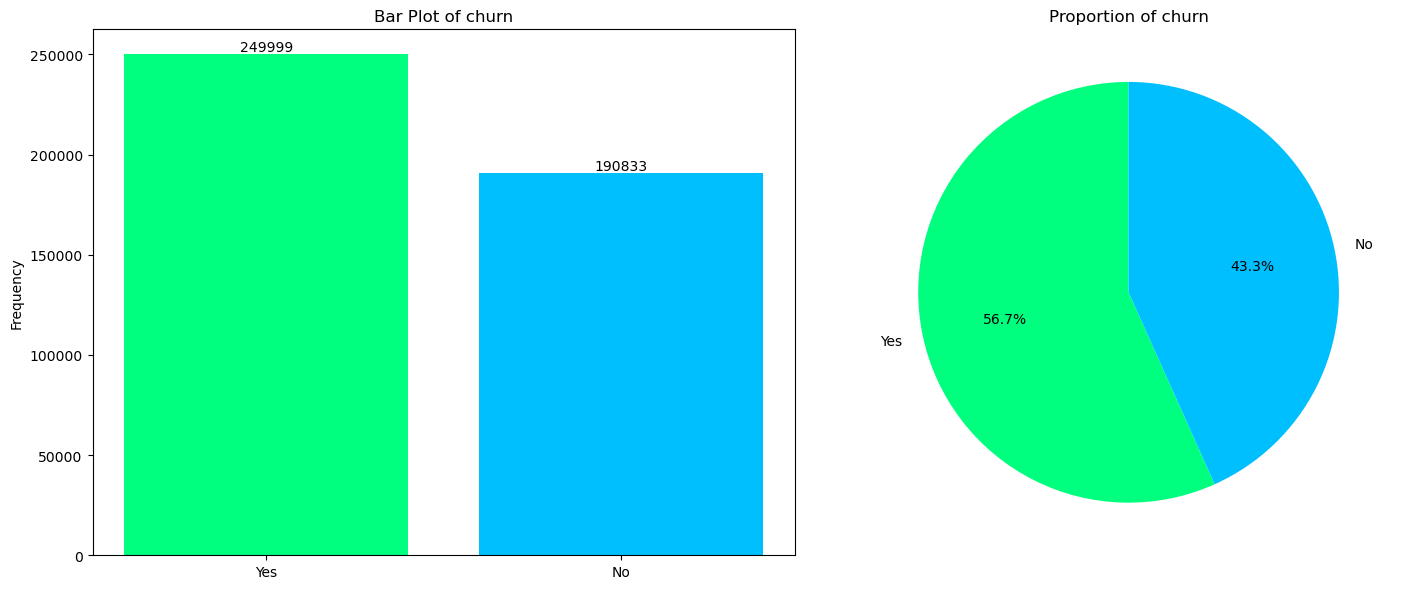

In [416]:
# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# barplot
dpnm_counts = df["churn"].value_counts()
barplot = ax1.bar(dpnm_counts.index, dpnm_counts.values, color=["springgreen", "deepskyblue"])

# label barplot
for bar, count in zip(barplot, dpnm_counts.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha="center", va="bottom")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["Yes", "No"])
ax1.set_ylabel("Frequency")
ax1.set_title("Bar Plot of churn")

# pie chart
dpnm_labels = ["Yes", "No"]
dpnm_sizes = df["churn"].value_counts().values
ax2.pie(dpnm_sizes, labels=dpnm_labels, autopct="%1.1f%%", colors=["springgreen", "deepskyblue"], startangle=90)

# label peichart
ax2.set_title("Proportion of churn")

# show plot
plt.tight_layout()
plt.show()

In [417]:
df["churn"].value_counts()

churn
True     249999
False    190833
Name: count, dtype: int64

In [388]:
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

# Features

## Feature Selection

In [305]:
# copy df_ori to dataframe named df_model
df_model = df.copy()

In [306]:
df_model

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2,30,Female,39,14,5,18,Standard,Annual,932.00,17,True
1,3,65,Female,49,1,10,8,Basic,Monthly,557.00,6,True
2,4,55,Female,14,4,6,18,Basic,Quarterly,185.00,3,True
3,5,58,Male,38,21,7,7,Standard,Monthly,396.00,29,True
4,6,23,Male,32,20,5,8,Basic,Monthly,617.00,20,True
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995,42,Male,54,15,1,3,Premium,Annual,716.38,8,False
440829,449996,25,Female,8,13,1,20,Premium,Annual,745.38,2,False
440830,449997,26,Male,35,27,1,5,Standard,Quarterly,977.31,9,False
440831,449998,28,Male,55,14,2,0,Standard,Quarterly,602.55,2,False


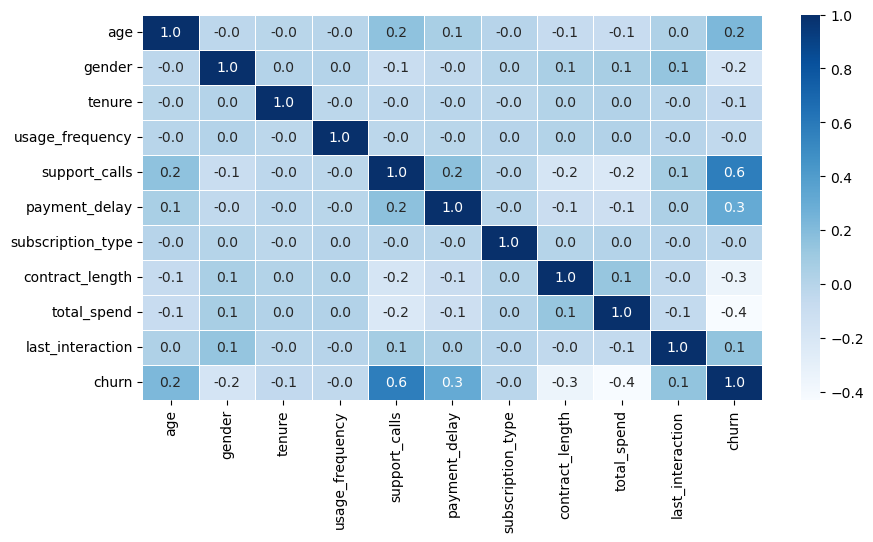

In [307]:
df_coor = df.copy()

df_coor["gender"] = df_coor["gender"].map({"Female": 0, "Male": 1})
df_coor["subscription_type"] = df_coor["subscription_type"].map({"Basic": 1, "Standard": 2, "Premium": 3})
df_coor["contract_length"] = df_coor["contract_length"].map({"Monthly": 1, "Quarterly": 2, "Annual": 3})
df_coor["churn"] = df_coor["churn"].map({"False": 0, "True": 1})

matrix = df_coor[['age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn']]

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix.corr("kendall"), annot=True, linewidths=0.5, fmt=".1f", ax=ax, cmap="Blues")
plt.show()

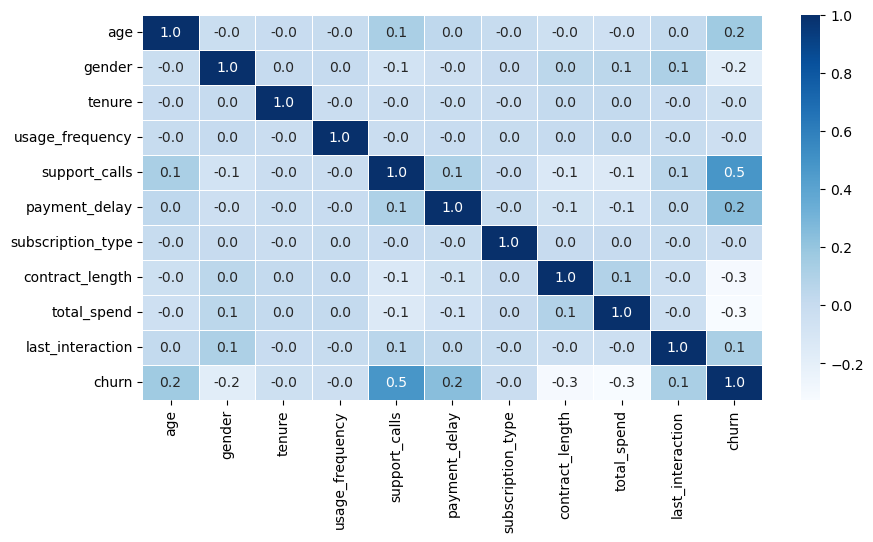

In [379]:
df_coor = df.copy()

df_coor["gender"] = df_coor["gender"].map({"Female": 0, "Male": 1})
df_coor["subscription_type"] = df_coor["subscription_type"].map({"Basic": 1, "Standard": 2, "Premium": 3})
df_coor["contract_length"] = df_coor["contract_length"].map({"Monthly": 1, "Quarterly": 2, "Annual": 3})
df_coor["churn"] = df_coor["churn"].map({"False": 0, "True": 1})

matrix = df_coor[['age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn']]

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix.corr("kendall"), annot=True, linewidths=0.5, fmt=".1f", ax=ax, cmap="Blues")
plt.show()

In [308]:
df_model.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [309]:
df_model = df_model[['age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn']]

In [310]:
df_model

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,30,Female,39,14,5,18,Standard,Annual,932.00,17,True
1,65,Female,49,1,10,8,Basic,Monthly,557.00,6,True
2,55,Female,14,4,6,18,Basic,Quarterly,185.00,3,True
3,58,Male,38,21,7,7,Standard,Monthly,396.00,29,True
4,23,Male,32,20,5,8,Basic,Monthly,617.00,20,True
...,...,...,...,...,...,...,...,...,...,...,...
440828,42,Male,54,15,1,3,Premium,Annual,716.38,8,False
440829,25,Female,8,13,1,20,Premium,Annual,745.38,2,False
440830,26,Male,35,27,1,5,Standard,Quarterly,977.31,9,False
440831,28,Male,55,14,2,0,Standard,Quarterly,602.55,2,False


## Labeling

In [311]:
df_model_labeled = df_model.copy()
df_model_labeled["gender"] = df_model_labeled["gender"].map({"Female": 1, "Male": 2})
df_model_labeled["subscription_type"] = df_model_labeled["subscription_type"].map({"Basic": 1, "Standard": 2, "Premium": 3})
df_model_labeled["contract_length"] = df_model_labeled["contract_length"].map({"Monthly": 1, "Quarterly": 2, "Annual": 3})

df_model_labeled["churn"] = df_model_labeled["churn"].map({"False": "Non_Churn", "True": "Churn"})

In [312]:
df_model_labeled

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,30,1,39,14,5,18,2,3,932.00,17,Churn
1,65,1,49,1,10,8,1,1,557.00,6,Churn
2,55,1,14,4,6,18,1,2,185.00,3,Churn
3,58,2,38,21,7,7,2,1,396.00,29,Churn
4,23,2,32,20,5,8,1,1,617.00,20,Churn
...,...,...,...,...,...,...,...,...,...,...,...
440828,42,2,54,15,1,3,3,3,716.38,8,Non_Churn
440829,25,1,8,13,1,20,3,3,745.38,2,Non_Churn
440830,26,2,35,27,1,5,2,2,977.31,9,Non_Churn
440831,28,2,55,14,2,0,2,2,602.55,2,Non_Churn


## Split X and Y

In [313]:
# feature
X = df_model_labeled.drop("churn", axis=1)

# target
y = df_model_labeled["churn"]

In [314]:
# check shape
print(X.shape)
print(y.shape)

(440832, 10)
(440832,)


In [315]:
X

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,30,1,39,14,5,18,2,3,932.00,17
1,65,1,49,1,10,8,1,1,557.00,6
2,55,1,14,4,6,18,1,2,185.00,3
3,58,2,38,21,7,7,2,1,396.00,29
4,23,2,32,20,5,8,1,1,617.00,20
...,...,...,...,...,...,...,...,...,...,...
440828,42,2,54,15,1,3,3,3,716.38,8
440829,25,1,8,13,1,20,3,3,745.38,2
440830,26,2,35,27,1,5,2,2,977.31,9
440831,28,2,55,14,2,0,2,2,602.55,2


## Column Type

In [316]:
y.value_counts()

churn
Churn        249999
Non_Churn    190833
Name: count, dtype: int64

In [317]:
num_col = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction']
cat_col_n = ['gender']
cat_col_o = ['subscription_type', 'contract_length']

## Split Train and Test

In [318]:
# split train and test set
random_state = 13
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=random_state)

# show X_train
X_train

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
74267,37,2,17,13,7,24,1,3,970.00,21
183414,63,1,28,19,5,20,1,3,526.00,24
9738,51,1,25,22,1,3,3,1,606.00,30
279209,28,2,25,21,1,1,1,3,852.67,28
152469,23,1,8,12,10,14,2,3,652.00,3
...,...,...,...,...,...,...,...,...,...,...
218869,27,1,3,16,4,7,1,2,688.69,16
164706,27,1,34,20,4,6,2,1,368.00,28
256743,35,2,52,6,2,6,2,3,513.24,10
253457,52,1,39,16,10,10,1,1,130.40,15


In [319]:
# check shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(374707, 10)
(374707,)
(66125, 10)
(66125,)


## Handling Outliers

In [320]:
# init col to check
columns_to_check = num_col

# init col_outliers
col_outliers = []

# init df_outliers
df_outliers = pd.DataFrame()

print("Outliers Overview:")
print("")

for col in columns_to_check:
    print(col)

    # skewness
    skew_col = X_train[col].skew()
    print(f"skewness {col}       = {skew_col}")
    if skew_col > 0.5 or skew_col < -0.5:
        print("distribusi skew")
    else:
        print("distribusi normal")

    # q1 q3 iqr
    q1_col = X_train[col].quantile(0.25)
    q3_col = X_train[col].quantile(0.75)
    iqr_col = q3_col - q1_col

    # lower upper boundary
    ub_col = q3_col + 1.5 * iqr_col
    lb_col = q1_col - 1.5 * iqr_col

    print(f"upper boundary {col} = {ub_col}")
    print(f"lower boundary {col} = {lb_col}")

    # outliers
    outlier_col = X_train[col][(X_train[col] < lb_col) | (X_train[col] > ub_col)]

    if len(outlier_col) > 0:
        # count and percentage of outliers
        persentase_outliers = len(outlier_col) / len(X_train[col]) * 100
        print(f"terdapat outliers sebanyak {len(outlier_col)} row")
        print(f"dengan persentase {(persentase_outliers):.2f}%")

        # min max outliers
        min_outlier_col = outlier_col.min()
        max_outlier_col = outlier_col.max()
        print(f"min outlier_{col} = {min_outlier_col}")
        print(f"max outlier_{col} = {max_outlier_col}")

        col_outliers.append({"column": col, "outliers": len(outlier_col), "%": f"{persentase_outliers:.2f}"})
        df_outliers = pd.concat([df_outliers, outlier_col], axis=1)
    else:
        print(f"tidak ada outliers untuk kolom {col}")

    print("")

# col_outliers to dataframe
col_outliers = pd.DataFrame(col_outliers)


Outliers Overview:

age
skewness age       = 0.16218317067586768
distribusi normal
upper boundary age = 76.5
lower boundary age = 0.5
tidak ada outliers untuk kolom age

tenure
skewness tenure       = -0.06208310337424153
distribusi normal
upper boundary tenure = 91.0
lower boundary tenure = -29.0
tidak ada outliers untuk kolom tenure

usage_frequency
skewness usage_frequency       = -0.04353007825945099
distribusi normal
upper boundary usage_frequency = 44.0
lower boundary usage_frequency = -12.0
tidak ada outliers untuk kolom usage_frequency

support_calls
skewness support_calls       = 0.6678655458060418
distribusi skew
upper boundary support_calls = 13.5
lower boundary support_calls = -6.5
tidak ada outliers untuk kolom support_calls

payment_delay
skewness payment_delay       = 0.26948748597739014
distribusi normal
upper boundary payment_delay = 38.5
lower boundary payment_delay = -13.5
tidak ada outliers untuk kolom payment_delay

total_spend
skewness total_spend       = -0.45750

In [321]:
# show column has an outliers
col_outliers

""


insight:
- tidak ada outliers

## Data Balancing

In [322]:
# check target proportion
y_train.value_counts()

churn
Churn        212454
Non_Churn    162253
Name: count, dtype: int64

insight:
- handling dengan oversampling

In [323]:
# smote over sample minor data
smote = SMOTE(sampling_strategy="minority", k_neighbors=5, random_state=13)

# smote train set
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# check value count after smote
y_train_balanced.value_counts()

churn
Churn        212454
Non_Churn    212454
Name: count, dtype: int64

In [324]:
# check shape
print(X_train_balanced.shape)
print(y_train_balanced.shape)
print(X_test.shape)
print(y_test.shape)

(424908, 10)
(424908,)
(66125, 10)
(66125,)


In [325]:
X_train_balanced

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,37,2,17,13,7,24,1,3,970.000000,21
1,63,1,28,19,5,20,1,3,526.000000,24
2,51,1,25,22,1,3,3,1,606.000000,30
3,28,2,25,21,1,1,1,3,852.670000,28
4,23,1,8,12,10,14,2,3,652.000000,3
...,...,...,...,...,...,...,...,...,...,...
424903,50,1,9,23,3,13,2,2,945.990888,15
424904,34,2,37,26,1,8,2,3,940.446706,6
424905,22,2,40,1,0,1,2,2,561.591468,2
424906,41,1,5,24,2,16,1,2,740.733796,13


In [326]:
X_train_balanced["gender"] = X_train_balanced["gender"].map({1: "Female", 2: "Male"})
X_train_balanced["subscription_type"] = X_train_balanced["subscription_type"].map({1: "Basic", 2: "Standard", 3: "Premium"})
X_train_balanced["contract_length"] = X_train_balanced["contract_length"].map({1: "Monthly", 2: "Quarterly", 3: "Annual"})

In [327]:
X_train_balanced

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,37,Male,17,13,7,24,Basic,Annual,970.000000,21
1,63,Female,28,19,5,20,Basic,Annual,526.000000,24
2,51,Female,25,22,1,3,Premium,Monthly,606.000000,30
3,28,Male,25,21,1,1,Basic,Annual,852.670000,28
4,23,Female,8,12,10,14,Standard,Annual,652.000000,3
...,...,...,...,...,...,...,...,...,...,...
424903,50,Female,9,23,3,13,Standard,Quarterly,945.990888,15
424904,34,Male,37,26,1,8,Standard,Annual,940.446706,6
424905,22,Male,40,1,0,1,Standard,Quarterly,561.591468,2
424906,41,Female,5,24,2,16,Basic,Quarterly,740.733796,13


In [328]:
X_test

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
126658,59,2,56,29,4,18,1,2,454.00,20
312635,41,1,50,29,4,20,2,2,574.71,12
214191,39,2,56,10,8,12,3,3,935.16,14
78965,22,1,8,1,1,13,3,1,199.00,19
267211,44,2,21,21,1,3,1,3,848.63,7
...,...,...,...,...,...,...,...,...,...,...
12557,63,2,13,2,3,28,1,2,502.00,26
352223,41,2,8,12,2,3,2,2,959.74,6
188236,64,2,3,16,4,14,3,1,620.00,16
225715,20,1,56,17,4,17,1,2,223.57,14


In [329]:
X_test["gender"] = X_test["gender"].map({1: "Female", 2: "Male"})
X_test["subscription_type"] = X_test["subscription_type"].map({1: "Basic", 2: "Standard", 3: "Premium"})
X_test["contract_length"] = X_test["contract_length"].map({1: "Monthly", 2: "Quarterly", 3: "Annual"})

In [330]:
X_test

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
126658,59,Male,56,29,4,18,Basic,Quarterly,454.00,20
312635,41,Female,50,29,4,20,Standard,Quarterly,574.71,12
214191,39,Male,56,10,8,12,Premium,Annual,935.16,14
78965,22,Female,8,1,1,13,Premium,Monthly,199.00,19
267211,44,Male,21,21,1,3,Basic,Annual,848.63,7
...,...,...,...,...,...,...,...,...,...,...
12557,63,Male,13,2,3,28,Basic,Quarterly,502.00,26
352223,41,Male,8,12,2,3,Standard,Quarterly,959.74,6
188236,64,Male,3,16,4,14,Premium,Monthly,620.00,16
225715,20,Female,56,17,4,17,Basic,Quarterly,223.57,14


## Scaler

In [331]:
scaler = StandardScaler()

X_train_balanced_scaled = scaler.fit_transform(X_train_balanced[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

## Encoding

### Nominal

In [332]:
X_train_balanced

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,37,Male,17,13,7,24,Basic,Annual,970.000000,21
1,63,Female,28,19,5,20,Basic,Annual,526.000000,24
2,51,Female,25,22,1,3,Premium,Monthly,606.000000,30
3,28,Male,25,21,1,1,Basic,Annual,852.670000,28
4,23,Female,8,12,10,14,Standard,Annual,652.000000,3
...,...,...,...,...,...,...,...,...,...,...
424903,50,Female,9,23,3,13,Standard,Quarterly,945.990888,15
424904,34,Male,37,26,1,8,Standard,Annual,940.446706,6
424905,22,Male,40,1,0,1,Standard,Quarterly,561.591468,2
424906,41,Female,5,24,2,16,Basic,Quarterly,740.733796,13


In [333]:
X_test

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
126658,59,Male,56,29,4,18,Basic,Quarterly,454.00,20
312635,41,Female,50,29,4,20,Standard,Quarterly,574.71,12
214191,39,Male,56,10,8,12,Premium,Annual,935.16,14
78965,22,Female,8,1,1,13,Premium,Monthly,199.00,19
267211,44,Male,21,21,1,3,Basic,Annual,848.63,7
...,...,...,...,...,...,...,...,...,...,...
12557,63,Male,13,2,3,28,Basic,Quarterly,502.00,26
352223,41,Male,8,12,2,3,Standard,Quarterly,959.74,6
188236,64,Male,3,16,4,14,Premium,Monthly,620.00,16
225715,20,Female,56,17,4,17,Basic,Quarterly,223.57,14


In [334]:
encoder_n = OneHotEncoder()

X_train_balanced_encoded_n = encoder_n.fit_transform(X_train_balanced[cat_col_n]).toarray()
X_test_encoded_n = encoder_n.transform(X_test[cat_col_n]).toarray()

### Ordinal

In [335]:
df_ori["subscription_type"].value_counts()

subscription_type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64

In [336]:
df_model_labeled["subscription_type"].value_counts()

subscription_type
2    149128
3    148678
1    143026
Name: count, dtype: int64

In [337]:
df_ori["contract_length"].value_counts()

contract_length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64

In [338]:
df_model_labeled["contract_length"].value_counts()

contract_length
3    177198
2    176530
1     87104
Name: count, dtype: int64

In [339]:
# # init value order
# subscription_type_order = [1, 2, 3]
# contract_length_order = [1, 2, 3]

# init value order text
subscription_type_text_order = ["Basic", "Standard", "Premium"]
contract_length_text_order = ["Monthly", "Quarterly", "Annual"]

In [340]:
# init OrdinalEncoder
encoder_o = OrdinalEncoder(categories=[subscription_type_text_order, contract_length_text_order])

# fit transform encoder_o
X_train_balanced_encoded_o = encoder_o.fit_transform(X_train_balanced[cat_col_o])
X_test_balanced_encoded_o = encoder_o.transform(X_test[cat_col_o])

## Concat

In [341]:
X_train_final = np.concatenate(
    [X_train_balanced_scaled, X_train_balanced_encoded_n, X_train_balanced_encoded_o], axis=1
)

X_test_final = np.concatenate(
    [X_test_scaled, X_test_encoded_n, X_test_balanced_encoded_o], axis=1
)

In [342]:
X_train_final = pd.DataFrame(X_train_final)
X_train_final

,0,1,2,3,4,5,6,7,8,9,10
0,-0.160101,-0.832302,-0.329060,1.223041,1.414082,1.382635,0.788673,0.0,1.0,0.0,2.0
1,1.980872,-0.194002,0.372597,0.557926,0.919685,-0.510177,1.139028,1.0,0.0,0.0,2.0
2,0.992731,-0.368084,0.723425,-0.772304,-1.181504,-0.169130,1.839740,1.0,0.0,2.0,0.0
3,-0.901207,-0.368084,0.606482,-0.772304,-1.428702,0.882446,1.606169,0.0,1.0,0.0,2.0
4,-1.312933,-1.354548,-0.446003,2.220714,0.178089,0.026973,-1.313461,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
424903,0.910386,-1.296520,0.840368,-0.107189,0.054489,1.280282,0.087961,1.0,0.0,1.0,1.0
424904,-0.407136,0.328244,1.191196,-0.772304,-0.563507,1.256646,-0.963106,0.0,1.0,1.0,2.0
424905,-1.395278,0.502326,-1.732374,-1.104862,-1.428702,-0.358447,-1.430247,0.0,1.0,1.0,1.0
424906,0.169280,-1.528630,0.957311,-0.439746,0.425287,0.405253,-0.145609,1.0,0.0,0.0,1.0


In [343]:
X_test_final = pd.DataFrame(X_test_final)
X_test_final

,0,1,2,3,4,5,6,7,8,9,10
0,1.651492,1.430763,1.542024,0.225369,0.672486,-0.817119,0.671888,0.0,1.0,0.0,1.0
1,0.169280,1.082599,1.542024,0.225369,0.919685,-0.302522,-0.262394,1.0,0.0,1.0,1.0
2,0.004589,1.430763,-0.679889,1.555599,-0.069110,1.234109,-0.028824,0.0,1.0,2.0,2.0
3,-1.395278,-1.354548,-1.732374,-0.772304,0.054489,-1.904206,0.555102,1.0,0.0,2.0,0.0
4,0.416315,-0.600193,0.606482,-0.772304,-1.181504,0.865224,-0.846321,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
66120,1.980872,-1.064411,-1.615431,-0.107189,1.908479,-0.612491,1.372599,0.0,1.0,0.0,1.0
66121,0.169280,-1.354548,-0.446003,-0.439746,-1.181504,1.338895,-0.963106,0.0,1.0,1.0,1.0
66122,2.063217,-1.644684,0.021768,0.225369,0.178089,-0.109446,0.204747,0.0,1.0,2.0,0.0
66123,-1.559968,1.430763,0.138711,0.225369,0.548887,-1.799462,-0.028824,1.0,0.0,0.0,1.0


# Model Definition

In [344]:
logres = LogisticRegression(max_iter=500)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB()
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm="SAMME")
catboost = CatBoostClassifier(verbose=0)
xgb = XGBClassifier()

# Model Train

In [345]:
logres.fit(X_train_final, y_train_balanced)

LogisticRegression(max_iter=500)

In [346]:
knn.fit(X_train_final, y_train_balanced)

KNeighborsClassifier()

In [347]:
dt.fit(X_train_final, y_train_balanced)

DecisionTreeClassifier()

In [348]:
rf.fit(X_train_final, y_train_balanced)

RandomForestClassifier()

In [349]:
nb.fit(X_train_final, y_train_balanced)

GaussianNB()

In [350]:
adaboost.fit(X_train_final, y_train_balanced)

AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier())

In [351]:
catboost.fit(X_train_final, y_train_balanced)

In [352]:
# xgb.fit(X_train_final, y_train_balanced)

# Model Evaluation

In [353]:
y_pred_train_logres = logres.predict(X_train_final)
y_pred_test_logres = logres.predict(X_test_final)

In [354]:
y_pred_train_knn = knn.predict(X_train_final)
y_pred_test_knn = knn.predict(X_test_final)

In [355]:
y_pred_train_dt = dt.predict(X_train_final)
y_pred_test_dt = dt.predict(X_test_final)

In [356]:
y_pred_train_rf = rf.predict(X_train_final)
y_pred_test_rf = rf.predict(X_test_final)

In [357]:
y_pred_train_nb = nb.predict(X_train_final)
y_pred_test_nb = nb.predict(X_test_final)

In [358]:
y_pred_train_adaboost = adaboost.predict(X_train_final)
y_pred_test_adaboost = adaboost.predict(X_test_final)

In [359]:
y_pred_train_catboost = catboost.predict(X_train_final)
y_pred_test_catboost = catboost.predict(X_test_final)

In [360]:
# y_pred_train_xgb = xgb.predict(X_train_final)
# y_pred_test_xgb = xgb.predict(X_test_final)

In [361]:
# cross validation score
cv_scores_logres = cross_val_score(logres, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
cv_scores_knn = cross_val_score(knn, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
cv_scores_dt = cross_val_score(dt, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
cv_scores_rf = cross_val_score(rf, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
cv_scores_nb = cross_val_score(nb, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
cv_scores_adaboost = cross_val_score(adaboost, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
cv_scores_catboost = cross_val_score(catboost, X_train_final, y_train_balanced, cv=5, scoring="accuracy")
# cv_scores_xgb = cross_val_score(xgb, X_train_final, y_train_balanced, cv=5, scoring="accuracy")

print("Cross-Validation (CV):")
print(f"CV Scores Logistic Regression   : {cv_scores_logres}")
print(f"CV Scores KNN                   : {cv_scores_knn}")
print(f"CV Scores Decision Tree         : {cv_scores_dt}")
print(f"CV Scores Random Forest         : {cv_scores_rf}")
print(f"CV Scores Naive Bayes           : {cv_scores_nb}")
print(f"CV Scores Adaboost              : {cv_scores_adaboost}")
print(f"CV Scores Catboost              : {cv_scores_catboost}")
# print(f"CV Scores XGBoost               : {cv_scores_xgb}")
print("")
print(f"Mean CV Score Logistic Regression   : {cv_scores_logres.mean():.4f}")
print(f"Mean CV Score KNN                   : {cv_scores_knn.mean():.4f}")
print(f"Mean CV Score Decision Tree         : {cv_scores_dt.mean():.4f}")
print(f"Mean CV Score Random Forest         : {cv_scores_rf.mean():.4f}")
print(f"Mean CV Score Naive Bayes           : {cv_scores_nb.mean():.4f}")
print(f"Mean CV Score Adaboost              : {cv_scores_adaboost.mean():.4f}")
print(f"Mean CV Score Catboost              : {cv_scores_catboost.mean():.4f}")
# print(f"Mean CV Score XGBoost               : {cv_scores_xgb.mean():.4f}")
print("")
print(f"Standard Deviation CV Scores Logistic Regression    : {cv_scores_logres.std():.4f}")
print(f"Standard Deviation CV Scores KNN                    : {cv_scores_knn.std():.4f}")
print(f"Standard Deviation CV Scores Decision Tree          : {cv_scores_dt.std():.4f}")
print(f"Standard Deviation CV Scores Random Forest          : {cv_scores_rf.std():.4f}")
print(f"Standard Deviation CV Scores Naive Bayes            : {cv_scores_rf.std():.4f}")
print(f"Standard Deviation CV Scores Adaboost               : {cv_scores_adaboost.std():.4f}")
# print(f"Standard Deviation CV Scores XGBoost                : {cv_scores_xgb.std():.4f}")

Cross-Validation (CV):
CV Scores Logistic Regression   : [0.87330258 0.87272599 0.87340849 0.87685483 0.87720785]
CV Scores KNN                   : [0.96249794 0.96167424 0.96134476 0.96161495 0.96125016]
CV Scores Decision Tree         : [0.99895272 0.99876444 0.99862324 0.99814076 0.99319848]
CV Scores Random Forest         : [0.99887035 0.99903509 0.99890565 0.99856438 0.99213942]
CV Scores Naive Bayes           : [0.93190323 0.93165612 0.93193853 0.93636225 0.94281075]
CV Scores Adaboost              : [0.99895272 0.99878798 0.99854087 0.99802309 0.99308081]
CV Scores Catboost              : [0.99908216 0.99892919 0.99892919 0.99865852 0.99169226]

Mean CV Score Logistic Regression   : 0.8747
Mean CV Score KNN                   : 0.9617
Mean CV Score Decision Tree         : 0.9975
Mean CV Score Random Forest         : 0.9975
Mean CV Score Naive Bayes           : 0.9349
Mean CV Score Adaboost              : 0.9975
Mean CV Score Catboost              : 0.9975

Standard Deviation CV S

In [362]:
# classification_report Logistic Regression
print("Evaluation Logistic Regression")
print("Train\n", classification_report(y_train_balanced, y_pred_train_logres))
print("Test\n", classification_report(y_test, y_pred_test_logres))
print("")

Evaluation Logistic Regression
Train
               precision    recall  f1-score   support

       Churn       0.89      0.85      0.87    212454
   Non_Churn       0.86      0.90      0.88    212454

    accuracy                           0.88    424908
   macro avg       0.88      0.88      0.88    424908
weighted avg       0.88      0.88      0.88    424908

Test
               precision    recall  f1-score   support

       Churn       0.91      0.85      0.88     37545
   Non_Churn       0.82      0.89      0.86     28580

    accuracy                           0.87     66125
   macro avg       0.87      0.87      0.87     66125
weighted avg       0.87      0.87      0.87     66125




In [363]:
# classification_report knn
print("Evaluation KNN")
print("Train\n", classification_report(y_train_balanced, y_pred_train_knn))
print("Test\n", classification_report(y_test, y_pred_test_knn))
print("")

Evaluation KNN
Train
               precision    recall  f1-score   support

       Churn       1.00      0.94      0.97    212454
   Non_Churn       0.95      1.00      0.97    212454

    accuracy                           0.97    424908
   macro avg       0.97      0.97      0.97    424908
weighted avg       0.97      0.97      0.97    424908

Test
               precision    recall  f1-score   support

       Churn       1.00      0.93      0.96     37545
   Non_Churn       0.91      1.00      0.95     28580

    accuracy                           0.96     66125
   macro avg       0.96      0.96      0.96     66125
weighted avg       0.96      0.96      0.96     66125




In [364]:
# classification_report Decision Tree
print("Evaluation Decision Tree")
print("Train\n", classification_report(y_train_balanced, y_pred_train_dt))
print("Test\n", classification_report(y_test, y_pred_test_dt))
print("")

Evaluation Decision Tree
Train
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00    212454
   Non_Churn       1.00      1.00      1.00    212454

    accuracy                           1.00    424908
   macro avg       1.00      1.00      1.00    424908
weighted avg       1.00      1.00      1.00    424908

Test
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00     37545
   Non_Churn       1.00      1.00      1.00     28580

    accuracy                           1.00     66125
   macro avg       1.00      1.00      1.00     66125
weighted avg       1.00      1.00      1.00     66125




In [365]:
# classification_report Random Forest
print("Evaluation Random Forest")
print("Train\n", classification_report(y_train_balanced, y_pred_train_rf))
print("Test\n", classification_report(y_test, y_pred_test_rf))
print("")

Evaluation Random Forest
Train
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00    212454
   Non_Churn       1.00      1.00      1.00    212454

    accuracy                           1.00    424908
   macro avg       1.00      1.00      1.00    424908
weighted avg       1.00      1.00      1.00    424908

Test
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00     37545
   Non_Churn       1.00      1.00      1.00     28580

    accuracy                           1.00     66125
   macro avg       1.00      1.00      1.00     66125
weighted avg       1.00      1.00      1.00     66125




In [366]:
# classification_report Naive Bayes
print("Evaluation Naive Bayes")
print("Train\n", classification_report(y_train_balanced, y_pred_train_nb))
print("Test\n", classification_report(y_test, y_pred_test_nb))
print("")

Evaluation Naive Bayes
Train
               precision    recall  f1-score   support

       Churn       0.96      0.91      0.93    212454
   Non_Churn       0.91      0.96      0.94    212454

    accuracy                           0.94    424908
   macro avg       0.94      0.94      0.94    424908
weighted avg       0.94      0.94      0.94    424908

Test
               precision    recall  f1-score   support

       Churn       0.97      0.91      0.94     37545
   Non_Churn       0.89      0.96      0.92     28580

    accuracy                           0.93     66125
   macro avg       0.93      0.93      0.93     66125
weighted avg       0.93      0.93      0.93     66125




In [367]:
# classification_report Adaboost
print("Evaluation Adaboost")
print("Train\n", classification_report(y_train_balanced, y_pred_train_adaboost))
print("Test\n", classification_report(y_test, y_pred_test_adaboost))
print("")

Evaluation Adaboost
Train
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00    212454
   Non_Churn       1.00      1.00      1.00    212454

    accuracy                           1.00    424908
   macro avg       1.00      1.00      1.00    424908
weighted avg       1.00      1.00      1.00    424908

Test
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00     37545
   Non_Churn       1.00      1.00      1.00     28580

    accuracy                           1.00     66125
   macro avg       1.00      1.00      1.00     66125
weighted avg       1.00      1.00      1.00     66125




In [368]:
# classification_report Catboost
print("Evaluation Catboost")
print("Train\n", classification_report(y_train_balanced, y_pred_train_catboost))
print("Test\n", classification_report(y_test, y_pred_test_catboost))
print("")

Evaluation Catboost
Train
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00    212454
   Non_Churn       1.00      1.00      1.00    212454

    accuracy                           1.00    424908
   macro avg       1.00      1.00      1.00    424908
weighted avg       1.00      1.00      1.00    424908

Test
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00     37545
   Non_Churn       1.00      1.00      1.00     28580

    accuracy                           1.00     66125
   macro avg       1.00      1.00      1.00     66125
weighted avg       1.00      1.00      1.00     66125




In [369]:
# # classification_report XGBoost
# print("Evaluation XGBoost")
# print("Train\n", classification_report(y_train_balanced, y_pred_train_xgb))
# print("Test\n", classification_report(y_test, y_pred_test_xgb))
# print("")

Evaluation Logistic Regression
Train
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00    212454
   Non_Churn       1.00      1.00      1.00    212454

    accuracy                           1.00    424908
   macro avg       1.00      1.00      1.00    424908
weighted avg       1.00      1.00      1.00    424908

Test
               precision    recall  f1-score   support

       Churn       1.00      1.00      1.00     37545
   Non_Churn       1.00      1.00      1.00     28580

    accuracy                           1.00     66125
   macro avg       1.00      1.00      1.00     66125
weighted avg       1.00      1.00      1.00     66125


Confusion Matrix - Train Set
[[212454      0]
 [     0 212454]]

Confusion Matrix - Test Set
[[37489    56]
 [    1 28579]]


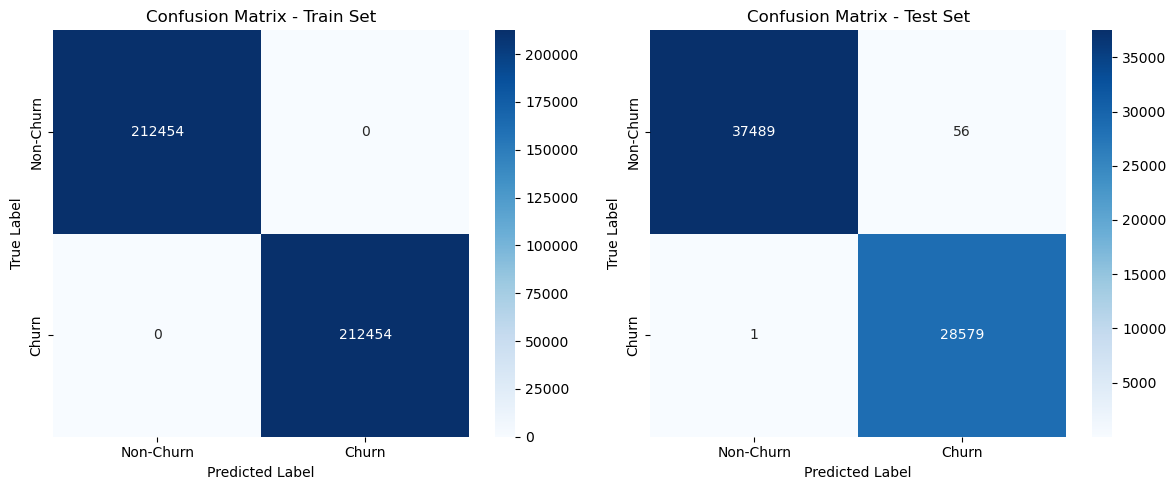

In [375]:
# Evaluasi Logistic Regression
print("Evaluation Logistic Regression")
print("Train\n", classification_report(y_train_balanced, y_pred_train_rf))
print("Test\n", classification_report(y_test, y_pred_test_rf))
print("")

# Confusion matrix untuk train set
cm_train = confusion_matrix(y_train_balanced, y_pred_train_rf)

# Confusion matrix untuk test set
cm_test = confusion_matrix(y_test, y_pred_test_rf)

# Print confusion matrix
print("Confusion Matrix - Train Set")
print(cm_train)
print("\nConfusion Matrix - Test Set")
print(cm_test)

# Confusion matrix untuk train set
cm_train = confusion_matrix(y_train_balanced, y_pred_train_rf)

# Confusion matrix untuk test set
cm_test = confusion_matrix(y_test, y_pred_test_rf)

# Confusion matrix display
plt.figure(figsize=(12, 5))

# Confusion matrix train set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Churn", "Churn"], yticklabels=["Non-Churn", "Churn"])
plt.title("Confusion Matrix - Train Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Confusion matrix test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Churn", "Churn"], yticklabels=["Non-Churn", "Churn"])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

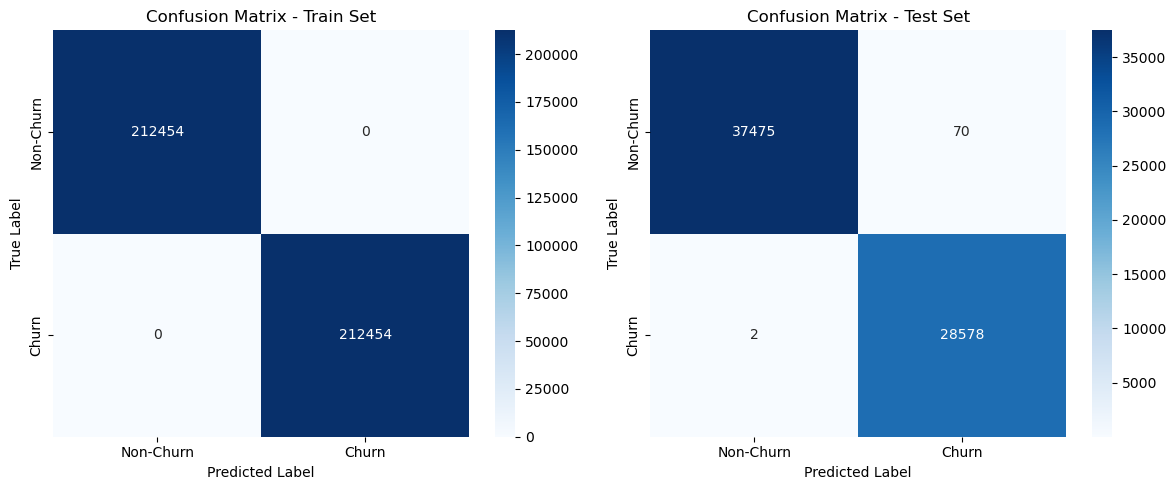

In [378]:
# Confusion matrix untuk train set
cm_train = confusion_matrix(y_train_balanced, y_pred_train_dt)

# Confusion matrix untuk test set
cm_test = confusion_matrix(y_test, y_pred_test_dt)

# Confusion matrix display
plt.figure(figsize=(12, 5))

# Confusion matrix train set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Churn", "Churn"], yticklabels=["Non-Churn", "Churn"])
plt.title("Confusion Matrix - Train Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Confusion matrix test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Churn", "Churn"], yticklabels=["Non-Churn", "Churn"])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

# Model Saving

In [372]:
X_train_final

,0,1,2,3,4,5,6,7,8,9,10
0,-0.160101,-0.832302,-0.329060,1.223041,1.414082,1.382635,0.788673,0.0,1.0,0.0,2.0
1,1.980872,-0.194002,0.372597,0.557926,0.919685,-0.510177,1.139028,1.0,0.0,0.0,2.0
2,0.992731,-0.368084,0.723425,-0.772304,-1.181504,-0.169130,1.839740,1.0,0.0,2.0,0.0
3,-0.901207,-0.368084,0.606482,-0.772304,-1.428702,0.882446,1.606169,0.0,1.0,0.0,2.0
4,-1.312933,-1.354548,-0.446003,2.220714,0.178089,0.026973,-1.313461,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
424903,0.910386,-1.296520,0.840368,-0.107189,0.054489,1.280282,0.087961,1.0,0.0,1.0,1.0
424904,-0.407136,0.328244,1.191196,-0.772304,-0.563507,1.256646,-0.963106,0.0,1.0,1.0,2.0
424905,-1.395278,0.502326,-1.732374,-1.104862,-1.428702,-0.358447,-1.430247,0.0,1.0,1.0,1.0
424906,0.169280,-1.528630,0.957311,-0.439746,0.425287,0.405253,-0.145609,1.0,0.0,0.0,1.0


In [373]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, num_col),
        ("cat_n", encoder_n, cat_col_n),
        ("cat_o", encoder_o, cat_col_o)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    # reduc_dimensi
    ("classifier", dt)
])

# pipeline.fit(X_train_final, y_train_balanced)
pipeline.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'tenure',
                                                   'usage_frequency',
                                                   'support_calls',
                                                   'payment_delay',
                                                   'total_spend',
                                                   'last_interaction']),
                                                 ('cat_n', OneHotEncoder(),
                                                  ['gender']),
                                                 ('cat_o',
                                                  OrdinalEncoder(categories=[['Basic',
                                                                              'Standard',
                                                                              'Premium'],
                                                                             ['Monthly',
                                                                              'Quarterly',
                                                                              'Annual']]),
                                                  ['subscription_type',
                                                   'contract_length'])])),
                ('classifier', DecisionTreeClassifier())])

In [374]:
joblib.dump(pipeline, "model/model_predict.pkl")

['model/model_predict.pkl']

# Inferencing

In [432]:
# load model.pkl
model_predict = joblib.load("model/model_predict.pkl")
model_cluster = joblib.load("model/model_cluster.pkl")

# data baru
new_data = pd.DataFrame([{
    'customerid': 132.0,
    'age': 30.0,
    'gender': 'Male',
    'tenure': 5.0,
    'usage_frequency': 25.0,
    'support_calls': 0.0,
    'payment_delay': 0.0,
    'subscription_type': 'Basic',
    'contract_length': 'Monthly',
    'total_spend': 4000.0,
    'last_interaction': 7.0,
    }])

# prediction
predict = model_predict.predict(new_data)
print("Hasil Prediksi: ", predict)

if predict == "Churn":
    new_data["churn"] = True
else:
    new_data["churn"] = False

# clustering
clustering = model_cluster.predict(new_data)
print("Hasil Clustering: ", clustering)
new_data["cluster"] = clustering
new_data.T

Hasil Prediksi:  ['Churn']
Hasil Clustering:  [3]


,0
customerid,132.0
age,30.0
gender,Male
tenure,5.0
usage_frequency,25.0
support_calls,0.0
payment_delay,0.0
subscription_type,Basic
contract_length,Monthly
total_spend,4000.0
